In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

from varname import nameof
import math

In [2]:
# !pip install gspread
# !pip install --upgrade oauth2client
# !pip install PyOpenSSL

import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

In [3]:
plt.style.use('seaborn')

<H1> Stock Option Classes </H1>

In [55]:
a = datetime.now()
b = datetime.strptime('2019-01-01', '%Y-%m-%d')
(b-a).days

-762

In [80]:
class Options:
    def __init__(self, ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price=0, max_price=100):
        self.exp_date = datetime.strptime(expiration, '%Y-%m-%d')
        self.exp_date_yr = self.exp_date.year
        self.exp_date_mon = self.exp_date.month
        self.exp_date_day = self.exp_date.day
        
        # format month and date as double digits
        if self.exp_date_mon < 10:
            self.exp_date_mon = '0' + str(self.exp_date_mon)
        if self.exp_date_day < 10:
            self.exp_date_day = '0' + str(self.exp_date_day)
        
        # calculate month from now
        curr_date = datetime.now()
        self.days_from_now = (self.exp_date - curr_date).days
        self.months_from_now = (self.exp_date.year - curr_date.year)*12 + (self.exp_date.month - curr_date.month)
        
        self.ticker = ticker
        self.expiration = expiration
        self.exp_date_trans = str(self.exp_date_yr)[-2:] + str(self.exp_date_mon) + str(self.exp_date_day)
        self.action = action
        self.strike = strike
        self.premium = premium
        self.curr_price = curr_price
        self.imp_vol = imp_vol
        self.min_price = min_price
        self.max_price = max_price
        self.payoff = [] 
        self.weighted_payoff = []
        self.return_ = []
        self.price_prob = {}
        self.breakeven =  -99
        self.payoff_min = -99
        self.payoff_max = -99
        self.return_min = -99
        self.return_max = -99
        self.avg_return = -99
             
        if action == 'buy':
            self.cost = round(premium, 1)
        elif action == 'sell':
            self.cost = round(-premium,1)

    def predict_price(self):

        self.std_dev = self.curr_price * self.imp_vol * np.sqrt(self.months_from_now/12)

        num_reps = 1000
        num_iter = 1000
        possible_prices = []

        # Generate all possible prices
        for i in range(num_iter):
            prices = np.random.normal(self.curr_price, self.std_dev, num_reps)
            prices = [int(x) if x>=0 else x for x in prices ]
            possible_prices.extend(prices)

        # count all the prices and create a dictionary
        price_counter = {}
        for price in possible_prices:
            if price_counter.get(price):
                price_counter[price]+=1
            else:
                price_counter[price] = 1 

        # Create a list of probabilities
        total_count = len(possible_prices)

        price_prob = [] 

        for price in range(self.min_price, self.max_price+1):
            if price_counter.get(price):
                prob = price_counter[price]/total_count
                price_prob.append(prob)
                self.price_prob[price] = prob
            else:
                price_prob.append(0)
                self.price_prob[price] = 0
        
    def calc_payoff(self):
        for price in range (self.min_price, self.max_price+1):
            earn = self.calc_profit(price)
            weighted_earn = earn * self.price_prob[price]
            self.payoff.append(earn)
            self.weighted_payoff.append(weighted_earn)
        
        try: self.breakeven = list(self.payoff).index(0)
        except: 
            minimum = min(self.payoff, key = abs)
            self.breakeven = list(self.payoff).index(minimum)
            
        self.breakeven  = round(self.breakeven,1)
        self.payoff_min = round(min(self.payoff),1)
        self.payoff_max = round(max(self.payoff),1)
        self.avg_payoff = round(sum(self.weighted_payoff),3)
        
    def calc_return(self):
        for payoff in self.payoff:
            return_ = round(payoff/self.cost,3)
            self.return_.append(return_)
        self.return_min = round(self.payoff_min/self.cost,3)
        self.return_max = round(self.payoff_max/self.cost,3)
        self.avg_return = round(self.avg_payoff/self.cost,3)
        self.avg_annualized_return = round(pow(1 + self.avg_return, 365/self.days_from_now)-1, 3)
    
    def create_graph(self):

        max_x = self.max_price
        min_x = self.min_price
        interval = (max_x - min_x)/10
        
        max_y = self.payoff_max + interval
        min_y = self.payoff_min - 5*interval
        
        x = np.arange(min_x, max_x +1, 1)
        y = self.payoff
        
#         print(len(x))

        print('Strategy:', self.name, 
              ';Payoff Range:[', self.payoff_min, ',', self.payoff_max, 
              '];Breakeven Price:', self.breakeven,
              ';Cost:', self.cost,
               ';Return Range:[', "{:.1%}".format(self.return_min), ',', "{:.1%}".format(self.return_max), ']',
              '; Avg. Return:',"{:.1%}".format(self.avg_return),
              '; Avg. Annual Return:',"{:.1%}".format(self.avg_annualized_return)
             )
        
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.xticks(np.arange(min_x, max_x+interval, interval))
        plt.yticks(np.arange(min_y, max_y, interval))
        
        plt.xlim (min_x, max_x) # limit range of x to show
        plt.ylim (min_y, max_y)
    #     plt.legend(loc = 'upper left')
        plt.plot(x, y, label = self.name )
        plt.legend()
        
    def create_graph_stock_only(self, current_price):
        max_x = self.max_price
        min_x = self.min_price
        interval = (max_x - min_x)/10
        
        max_y = self.payoff_max + interval
        min_y = self.payoff_min - 5*interval
        
        x = np.arange(min_x, max_x+1, 1)
        y = [a - current_price for a in x]
        
        payoff_min = round(min(x) - current_price,1)
        payoff_max = round(max(x) - current_price, 1)
        cost = round(current_price,1)
        return_min = round(payoff_min/cost,3)
        return_max = round(payoff_max/cost,3)
        current_price = round(current_price,1)

        print('Strategy: Stock Only;', 
              'Payoff Range:[', payoff_min, ',', payoff_max, 
              '];Breakeven Price:', current_price,
              'Cost:', cost,
              ';Return Range:[', "{:.1%}".format(return_min), ',', "{:.1%}".format(return_max), ']'
#               '; Average Return:',"{:.1%}".format(self.avg_return)
             )
        plt.xticks(np.arange(0, max_x+interval, interval))
        plt.yticks(np.arange(min_y , max_y, interval))
    #     plt.legend(loc = 'upper left')
        plt.xlim (min_x, max_x)
        plt.ylim (min_y, max_y)
        plt.plot(x, y, label = 'Stock Only' )
        plt.legend()

In [81]:
class Call(Options):
    def __init__(self, ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price=0, max_price=100):
        super().__init__(ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price, max_price)
        self.name = self.ticker + self.exp_date_trans + 'C'+ str(self.strike)
        self.type = 'call'
        self.predict_price()
        self.calc_payoff()
        self.calc_return()
        
        
    def calc_profit(self, price):
        if self.action == 'buy':
            if price <= self.strike:
                profit =  -self.premium
            elif price > self.strike:
                profit = price - self.strike - self.premium
            
        elif self.action == 'sell':
            if price <= self.strike:
                profit = self.premium
            elif price > self.strike:
                profit = - price + self.strike + self.premium
                
        return profit
      

In [82]:
class Put(Options):
    def __init__(self, ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price=0, max_price=100):
        super().__init__(ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price, max_price)
        self.name = self.ticker + self.exp_date_trans + 'P'+ str(self.strike)
        self.type = 'put'
        self.predict_price()
        self.calc_payoff()
        self.calc_return()
        
    def calc_profit(self, price):
        if self.action == 'buy':
            if price <= self.strike:
                profit = self.strike - price - self.premium
            elif price > self.strike:
                profit = - self.premium
            
        elif self.action == 'sell':
            if price <= self.strike:
                profit = - self.strike + price + self.premium
            elif price > self.strike:
                profit = self.premium
        return profit
            

In [83]:
class OptionsStrategy:
    def __init__(self, options_list, coefficients = []):
        self.ticker = options_list[0].ticker
        self.exp_date_trans = options_list[0].exp_date_trans
        self.min_price = options_list[0].min_price
        self.max_price = options_list[0].max_price
        self.options_list = options_list
        self.coefficients = coefficients
        
        self.payoff = []
        self.return_ = []
        self.breakeven = -99
        self.payoff_min = -99
        self.payoff_max = -99
        self.return_min = -99
        self.return_max = -99
        self.avg_return = -99

        self.create_name()
        self.calc_payoff()
        self.calc_return()
    
    def create_name(self):
        self.name = self.ticker + self.exp_date_trans
        for option in self.options_list:
            # Add action, option type, strike price to combo name
            if option.action == 'buy':
                self.name+='_B'
            elif option.action == 'sell':
                self.name+='_S'
                
            if option.type == 'call':
                self.name+='C'
            elif option.type == 'put':
                self.name+='P'
            
            self.name+=str(option.strike)
            
    def calc_payoff(self):
        self.cost = 0
        data_shape = len(self.options_list[0].payoff)
        if len(self.coefficients) == 0:
            self.coefficients = np.ones(data_shape)
            
        for index, option in enumerate(self.options_list):
            self.cost+=self.coefficients[index] * option.cost
            if len(self.payoff)==0:
                self.payoff = self.coefficients[index] * np.array(option.payoff) 
            else:
                self.payoff = np.add(self.payoff, 
                                     self.coefficients[index] * np.array(option.payoff)
                                    )
        self.cost = round(self.cost, 1)
            
        
        # calculate breakeven, payoff_min, payoff_max
        try: self.breakeven = list(self.payoff).index(0)
        except: 
            minimum = min(self.payoff, key = abs)
            self.breakeven = list(self.payoff).index(minimum)
            
        self.breakeven  = round(self.breakeven,1)
        self.payoff_min = round(min(self.payoff),1)
        self.payoff_max = round(max(self.payoff),1)
        
    
    def calc_return(self):
        for payoff in self.payoff:
            return_ = round(payoff/self.cost,3)
            self.return_.append(return_)
        self.return_min = round(self.payoff_min/self.cost,3)
        self.return_max = round(self.payoff_max/self.cost,3)
        self.avg_return = np.abs(np.mean(self.return_))
        
    
    def create_graph(self):
        
        max_x = self.max_price
        min_x = self.min_price
        interval = (max_x - min_x)/10
        
        max_y = self.payoff_max + interval
        min_y = self.payoff_min - 5*interval
        
        x = np.arange(min_x, max_x +1, 1)
        y = self.payoff

        print('Strategy:', self.name, 
              ';Payoff Range:[', self.payoff_min, ',', self.payoff_max, 
              '];Breakeven Price:', self.breakeven,
              ';Cost:', self.cost,
               ';Return Range:[', "{:.1%}".format(self.return_min), ',', "{:.1%}".format(self.return_max), ']',
              '; Avg. Return:',"{:.1%}".format(self.avg_return)
             )
        
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.xticks(np.arange(min_x, max_x+interval, interval))
        plt.yticks(np.arange(min_y, max_y, interval))
        plt.xlim (min_x, max_x) # limit range of x to show
        plt.ylim (min_y, max_y)
    #     plt.legend(loc = 'upper left')
        plt.plot(x, y, label = self.name )
        plt.legend()
        
    
    def create_graph_stock_only(self, current_price):
        max_x = self.max_price
        min_x = self.min_price
        interval = (max_x - min_x)/10
        max_y = self.payoff_max + interval
        min_y = self.payoff_min - 5*interval

        x = np.arange(min_x, max_x+1, 1)
        y = [a - current_price for a in x]

        payoff_min = round(min(x) - current_price,1)
        payoff_max = round(max(x) - current_price,1)
        cost = round(current_price,1)
        return_min = round(payoff_min/cost,3)
        return_max = round(payoff_max/cost,3)
        current_price = round(current_price,1)

        print('Strategy: Stock Only;', 
              'Payoff Range:[', payoff_min, ',', payoff_max, 
              '];Breakeven Price:', current_price,
              'Cost:', cost,
              ';Return Range:[', "{:.1%}".format(return_min), ',', "{:.1%}".format(return_max), ']',
#               '; Average Return:',"{:.0%}".format(self.avg_return)
             )
        plt.xticks(np.arange(min_x, max_x+interval, interval))
        plt.yticks(np.arange(min_y, max_y, interval))
        plt.xlim (min_x, max_x) # limit range of x to show
        plt.ylim (min_y, max_y)
    #     plt.legend(loc = 'upper left')
        plt.plot(x, y, label = 'Stock Only' )
        plt.legend()
             

<h1>Applications</H1>

Strategy: NIO250102C20 ;Payoff Range:[ -48 , 32 ];Breakeven Price: 68 ;Cost: 48 ;Return Range:[ -100.0% , 66.7% ] ; Avg. Return: -22.5% ; Avg. Annual Return: -6.3%


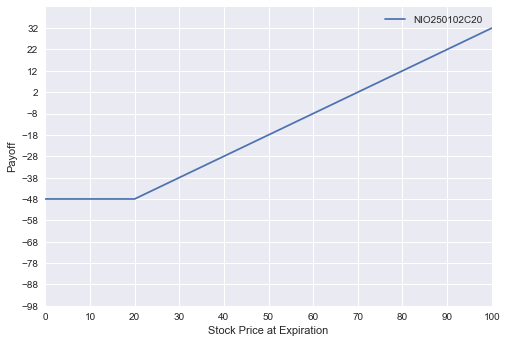

In [86]:
bc20 = Call('NIO', '2025-01-02', 'buy', 20, 48, 58, 0.33)
bc20.create_graph()

Strategy: NIO250102C20 ;Payoff Range:[ -48 , 32 ];Breakeven Price: 68 ;Cost: 48 ;Return Range:[ -100.0% , 66.7% ] ; Avg. Return: -22.5% ; Avg. Annual Return: -6.3%
Strategy: NIO250310C50 ;Payoff Range:[ -35 , 15 ];Breakeven Price: 65 ;Cost: -15 ;Return Range:[ 233.3% , -100.0% ] ; Avg. Return: -12.2% ; Avg. Annual Return: -3.1%
Strategy: NIO250105P30 ;Payoff Range:[ -35 , -5 ];Breakeven Price: 0 ;Cost: 35 ;Return Range:[ -100.0% , -14.3% ] ; Avg. Return: -74.1% ; Avg. Annual Return: -29.1%
Strategy: NIO250105P60 ;Payoff Range:[ -52 , 8 ];Breakeven Price: 52 ;Cost: -8 ;Return Range:[ 650.0% , -100.0% ] ; Avg. Return: 63.7% ; Avg. Annual Return: 13.4%
Strategy: Stock Only; Payoff Range:[ -60 , 40 ];Breakeven Price: 60 Cost: 60 ;Return Range:[ -100.0% , 66.7% ]


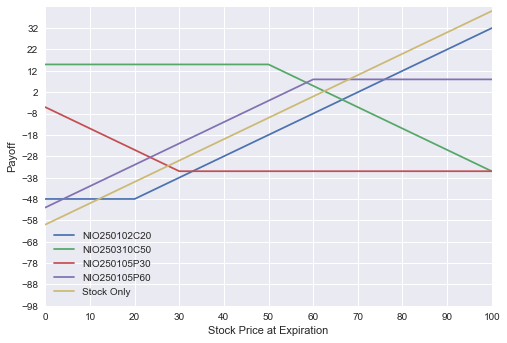

In [89]:
bc20 = Call('NIO', '2025-01-02', 'buy', 20, 48, 58, 0.33)
sc50 = Call('NIO', '2025-03-10', 'sell', 50, 15, 58, 0.33)
bp30 = Put('NIO', '2025-01-05', 'buy', 30, 35, 58, 0.33)
sp60 = Put('NIO', '2025-01-05', 'sell', 60, 8, 58, 0.33)

# create_graph(bc20.name, bc20.payoff, bc20.cost)
# create_graph(sc50.name, sc50.payoff, sc50.cost)
# create_graph(bp30.name, bp30.payoff, bp30.cost)
# create_graph(sp60.name, sp60.payoff, sp60.cost)

bc20.create_graph()
sc50.create_graph()
bp30.create_graph()
sp60.create_graph()

bc20.create_graph_stock_only(60)


Strategy: NIO250102_BC20_SC50 ;Payoff Range:[ -33.0 , -3.0 ];Breakeven Price: 50 ;Cost: 33.0 ;Return Range:[ -100.0% , -9.1% ] ; Avg. Return: 41.0%
Strategy: NIO250310_SC50_SP60 ;Payoff Range:[ -37.0 , 13.0 ];Breakeven Price: 37 ;Cost: -23.0 ;Return Range:[ 160.9% , -56.5% ] ; Avg. Return: 33.7%
Strategy: Stock Only; Payoff Range:[ -60 , 40 ];Breakeven Price: 60 Cost: 60 ;Return Range:[ -100.0% , 66.7% ]


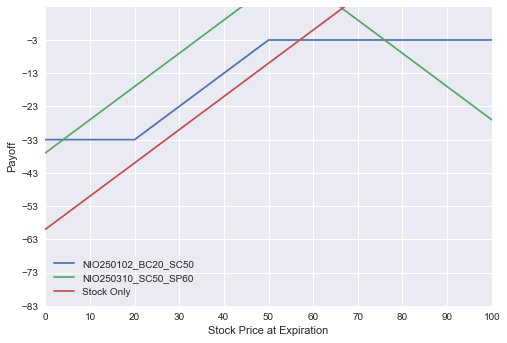

In [90]:
# optioin_strategy: approach #2 - OptionStrategy


bc20_sc50 = OptionsStrategy([bc20, sc50])
sc50_sp60 = OptionsStrategy([sc50, sp60])

bc20_sc50.create_graph()
sc50_sp60.create_graph()
bc20_sc50.create_graph_stock_only(60)

Strategy: NIO210501_BC50_SC80 ;Payoff Range:[ -5.0 , 25.0 ];Breakeven Price: 55 ;Cost: 5.0 ;Return Range:[ -100.0% , 500.0% ] ; Avg. Return: 110.9%
Strategy: Stock Only; Payoff Range:[ -60 , 40 ];Breakeven Price: 60 Cost: 60 ;Return Range:[ -100.0% , 66.7% ]


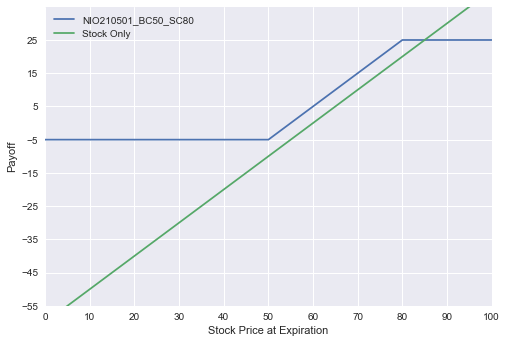

In [92]:
# Bull Spread Strategy: buy call 50 and sell call 80

bc50 = Call('NIO', '2021-05-01', 'buy', 50, 20, 58, 0.33)
sc80 = Call('NIO', '2021-05-01', 'sell', 80, 15, 58, 0.33)

bc50_sc80 = OptionsStrategy([bc50, sc80])

bc50_sc80.create_graph()
bc50_sc80.create_graph_stock_only(60)

In [ ]:
# Straddle Strategy: buy call 50 and buy put 50

bc50 = Call('NIO', '2021-05-01', 'buy', 50, 20)
bp50 = Put('NIO', '2021-05-01', 'buy', 50, 15)

bc50_sc80 = OptionsStrategy([bc50, bp50])

bc50_sc80.create_graph()
bc50_sc80.create_graph_stock_only(60)

In [ ]:
# Butterfly Spread Strategy: buy 1 call 50, sell 2 call 60, and buy a call 70

bc50 = Call('NIO', '2021-05-01', 'buy', 50, 12)
sc60 = Call('NIO', '2021-05-01', 'sell', 60, 5)
bc70 = Call('NIO', '2021-05-01', 'buy', 70, 2)

bc50_sc60_bc70 = OptionsStrategy([bc50, sc60, bc70], coefficients = [1, 2, 1])

bc50_sc60_bc70.create_graph()
bc50_sc60_bc70.create_graph_stock_only(60)

In [ ]:
# Stragegy: buy call @3 and buy put @5

nio_bc3 = Call('NIO', '2023-01-20', 'buy', 3, 58.38, max_price=200)
nio_bp5 = Put('NIO', '2023-01-20', 'buy', 5, 0.59, max_price=200)

nio_bc3_bp5 = OptionsStrategy([nio_bc3, nio_bp5])

nio_bc3_bp5.create_graph()
nio_bc3_bp5.create_graph_stock_only(60)

In [ ]:
# NIO strategies

nio_bc3 = Call('NIO', '2023-01-20', 'buy', 3, 58.38, max_price=200)
nio_bp5 = Put('NIO', '2023-01-20', 'buy', 5, 0.59, max_price=200)
nio_sp45 = Put('NIO', '2023-01-20', 'sell', 45, 18.45, max_price=200)
nio_sp60 = Put('NIO', '2023-01-20', 'sell', 60, 29.5, max_price=200)
nio_sp70 = Put('NIO', '2023-01-20', 'sell', 70, 37.3, max_price=200)
nio_sp80 = Put('NIO', '2023-01-20', 'sell', 80, 44.5, max_price=200)
nio_sp85 = Put('NIO', '2023-01-20', 'sell', 85, 45, max_price=200)
nio_sp100 = Put('NIO', '2023-01-20', 'sell', 100, 61.05, max_price=200)


s1 = OptionsStrategy([nio_bc3, nio_bp5])
s2 = OptionsStrategy([nio_bc3, nio_sp45])
s3 = OptionsStrategy([nio_bc3, nio_sp60])
s4 = OptionsStrategy([nio_bc3, nio_sp70])
s5 = OptionsStrategy([nio_bc3, nio_sp80])
s6 = OptionsStrategy([nio_bc3, nio_sp85])
s7 = OptionsStrategy([nio_bc3, nio_sp100])


for strategy in [s1, s2, s3, s4, s5, s6, s7]:
    strategy.create_graph()

s1.create_graph_stock_only(60)

In [ ]:
# Riot Strategy

s1 = Call('RIOT', '2023-01-20', 'buy', 7, 22.10,    max_price=100)
s2 = Call('RIOT', '2023-01-20', 'buy', 10, 20.25,   max_price=100)
s3 = Call('RIOT', '2023-01-20', 'buy', 12, 20.55,   max_price=100)
s4 = Call('RIOT', '2023-01-20', 'buy', 15, 20,      max_price=100)
s5 = Call('RIOT', '2023-01-20', 'buy', 17, 18.55,   max_price=100)
s6 = Call('RIOT', '2023-01-20', 'buy', 20, 18.85,   max_price=100)
s7 = Call('RIOT', '2023-01-20', 'buy', 25, 18.45,   max_price=100)
s8 = Call('RIOT', '2023-01-20', 'buy', 30, 17.10,   max_price=100)
s9 = Call('RIOT', '2023-01-20', 'buy', 35, 16,      max_price=100)


for strategy in [s1, s2, s3, s4, s5, s6, s7, s8, s9]:
    strategy.create_graph()

s1.create_graph_stock_only(25.84)

In [ ]:
# ARK Calls

s1  = Call('ARKK', '2023-01-20', 'buy', 47.96, 100.80,   max_price=300)
s2  = Call('ARKK', '2023-01-20', 'buy', 67.96, 85.30,    max_price=300)
s3  = Call('ARKK', '2023-01-20', 'buy', 77.96, 77.90,    max_price=300)
s4  = Call('ARKK', '2023-01-20', 'buy', 87.96, 71.10,    max_price=300)
s5  = Call('ARKK', '2023-01-20', 'buy', 107.96, 60.10,   max_price=300)
s6  = Call('ARKK', '2023-01-20', 'buy', 117.96, 56.40,   max_price=300)
s7  = Call('ARKK', '2023-01-20', 'buy', 127.96, 51.30,   max_price=300)
s8  = Call('ARKK', '2023-01-20', 'buy', 137.96, 46.90,   max_price=300)
s9  = Call('ARKK', '2023-01-20', 'buy', 147.96, 42.70,   max_price=300)
s10 = Call('ARKK', '2023-01-20', 'buy', 157.96, 39.90,   max_price=300)
s11 = Call('ARKK', '2023-01-20', 'buy', 167.96, 36.90,   max_price=300)
s12 = Call('ARKK', '2023-01-20', 'buy', 182.96, 31.40,   max_price=300)
s13 = Call('ARKK', '2023-01-20', 'buy', 200, 26.70,      max_price=300)

for strategy in [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13]:
    strategy.create_graph()

s1.create_graph_stock_only(143.94)

In [ ]:
# 1/19/21
# ARK Calls

s1  = Call('ARKK', '2023-01-20', 'buy', 47.96, 106,   max_price=300)
s2  = Call('ARKK', '2023-01-20', 'buy', 67.96, 90,    max_price=300)
s3  = Call('ARKK', '2023-01-20', 'buy', 77.96, 82,    max_price=300)
s4  = Call('ARKK', '2023-01-20', 'buy', 97.96, 70.5,    max_price=300)
s5  = Call('ARKK', '2023-01-20', 'buy', 98.96, 69.5,   max_price=300)
s6  = Call('ARKK', '2023-01-20', 'buy', 100, 69.5,   max_price=300)
s7  = Call('ARKK', '2023-01-20', 'buy', 107.96, 64.5,   max_price=300)
s8  = Call('ARKK', '2023-01-20', 'buy', 117.96, 60,   max_price=300)
s9  = Call('ARKK', '2023-01-20', 'buy', 127.96, 54.60,   max_price=300)
s10  = Call('ARKK', '2023-01-20', 'buy', 137.96, 51,   max_price=300)
s11  = Call('ARKK', '2023-01-20', 'buy', 147.96, 46.90,   max_price=300)
s12 = Call('ARKK', '2023-01-20', 'buy', 157.96, 44,   max_price=300)
s13 = Call('ARKK', '2023-01-20', 'buy', 167.96, 40.50,   max_price=300)
s14 = Call('ARKK', '2023-01-20', 'buy', 182.96, 35.20,   max_price=300)
s15 = Call('ARKK', '2023-01-20', 'buy', 200, 30.5,      max_price=300)
s16 = Call('ARKK', '2023-01-20', 'buy', 215, 26.5,      max_price=300)



for strategy in [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13, s14, s15, s16]:
    strategy.create_graph()

s1.create_graph_stock_only(141.91)

In [ ]:
c1 = Call('TSLA', '2021-01-29', 'buy', 830, 65.75, min_price=700,  max_price=1000)
c2 = Call('TSLA', '2023-01-29', 'buy', 850, 54,    min_price=700,    max_price=1000)
c3 = Call('TSLA', '2023-01-29', 'buy', 870, 44.2,  min_price=700,  max_price=1000)
c4 = Call('TSLA', '2023-01-29', 'buy', 875, 41.8,  min_price=700,  max_price=1000)

p1 = Put('TSLA', '2023-01-29', 'buy', 800, 9.95,   min_price=700, max_price=1000)
p2 = Put('TSLA', '2023-01-29', 'buy', 850, 27.15,  min_price=700, max_price=1000)
p3 = Put('TSLA', '2023-01-29', 'buy', 870, 37.60,  min_price=700, max_price=1000)
p4 = Put('TSLA', '2023-01-29', 'buy', 875, 40.40,  min_price=700, max_price=1000)


s1 = OptionsStrategy([c1, p1])
s2 = OptionsStrategy([c2, p2])
s3 = OptionsStrategy([c3, p3])
s4 = OptionsStrategy([c4, p4])
s5 = OptionsStrategy([c4, p1])


for strategy in [s1, s2, s3, s4]:
    strategy.create_graph()
s1.create_graph_stock_only(876.38)

<h1> Google Sheet Helper </h1>

In [ ]:
def read_google_sheet(google_sheet_name, tab_name):

    scope = ['https://spreadsheets.google.com/feeds',
             'https://www.googleapis.com/auth/drive']

    credentials = ServiceAccountCredentials.from_json_keyfile_name(
             '../../backup/google_api/stock-options-assessment-236c62880c44.json', scope) # Your json file here

    client = gspread.authorize(credentials)
    spreadsheetName = google_sheet_name
    sheetName = tab_name
    
    spreadsheet = client.open(spreadsheetName)
    sheet = spreadsheet.worksheet(sheetName)
    
    data = sheet.get_all_values()
    headers = data.pop(0)

    df = pd.DataFrame(data, columns=headers)
    display(df.head())
    
    return df

In [ ]:
df = read_google_sheet("stock_options_data", "nio_210118")

In [ ]:
std = 61.95*0.9531*np.sqrt(5/12)

<H1> Monte Carlo Price Prediction </H1>

In [ ]:
def predict_price(curr_price, imp_vol, exp_date):

    exp_date = datetime.strptime(exp_date, '%Y-%m-%d')
    curr_date = datetime.now()
    month_from_now = (exp_date.year - curr_date.year)*12 + (exp_date.month - curr_date.month) 



    std_dev = curr_price * imp_vol * np.sqrt(month_from_now/12)

    num_reps = 1000
    num_iter = 1000
    possible_prices = []

    # Generate all possible prices
    for i in range(num_iter):
        prices = np.random.normal(curr_price, std_dev, num_reps)
        prices = [int(x) if x>=0 else x for x in prices ]
        possible_prices.extend(prices)

    # count all the prices and create a dictionary
    price_counter = {}
    for price in possible_prices:
        if price_counter.get(price):
            price_counter[price]+=1
        else:
            price_counter[price] = 1 

    # Create a list of counts and a list of probabilities
    max_price = 200
    total_count = len(possible_prices)

    price_count = []
    price_prob = [] 


    for price in range(max_price):
        if price_counter.get(price):
            price_count.append(price_counter[price])

            prob = price_counter[price]/total_count
            price_prob.append(prob)
        else:
            price_count.append(0)
            price_prob.append(0)


    plt.bar(range(max_price), price_count)

In [ ]:
curr_price = 61.95
imp_vol = 0.9531
exp_date = '2021-05-18'

predict_price(curr_price, imp_vol, exp_date)